# Never Test for Normality

Way back in 2013, I wrote [this blog post](https://allendowney.blogspot.com/2013/08/are-my-data-normal.html) explaining why you should never use a statistical test to check whether a sample came from a Gaussian distribution.

I argued that data from the real world never come from a Gaussian distribution, or any other simple mathematical model, so the answer to the question is always no.

And there are only two possible outcomes from the test:

* If you have enough data, the test will reject the hypothesis that the data came from a Gaussian distribution, or

* If you don't have enough data, the test will fail to reject the hypothesis.

Either way, the result doesn't tell you anything useful.

In this article, I will explore a particular example and demonstrate this relationship between the sample size and the outcome of the test. And I will conclude, again, that

> Choosing a distribution is not a statistical question; it is a modeling decision.  No statistical test can tell you whether a particular distribution is a good model for your data. 

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/master/examples/anderson.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

I'll start by generating a sample that is actually from a lognormal distribution.

In [3]:
from scipy.stats import norm

dist = norm(2, 0.2)
logs = dist.rvs(200)
sample = np.exp(logs)

I'll use the sample mean and standard deviation to make a Gaussian model of the sample.

In [4]:
mu, sigma = sample.mean(), sample.std()

low, high = mu - 3.5*sigma, mu + 3.5*sigma
xs = np.linspace(low, high)
ys = norm.cdf(xs, mu, sigma)

Here's what the empirical distribution of the sample looks like compared to the CDF of the Gaussian distribution.

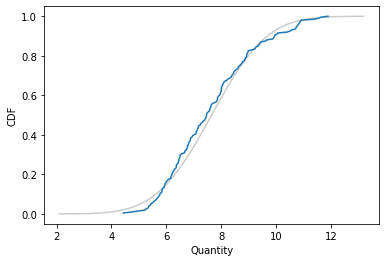

In [5]:
from empiricaldist import Cdf

plt.plot(xs, ys, color='gray', alpha=0.4)
Cdf.from_seq(sample).plot()
plt.xlabel('Quantity')
plt.ylabel('CDF')
plt.savefig("anderson1.png", dpi=300);

It looks like the Gaussian distribution is a pretty good model for the data, and probably good enough for most purposes.

Let's see what the [Anderson-Darling test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html) has to say:

In [6]:
from scipy.stats import anderson

statistic, critical_values, significance_level = anderson(sample)
statistic

1.7262363980891564

In [7]:
significance_level

array([15. , 10. ,  5. ,  2.5,  1. ])

In [8]:
critical_values[2]

0.772

The A-D statistic is 1.7, which exceeds the critical value, 0.77, so at the 5% significance level, we can reject the hypothesis that this sample came from a Gaussian distribution. That's the right answer, so it might seem like we've done something useful. But we haven't.


## Sample size

The result from the A-D test depends on the sample size. To demonstrate, I'll wrap the test in a function that returns a boolean.

In [9]:
def anderson_test(sample):
    statistic, critical_values, _ = anderson(sample)
    return statistic > critical_values[2]

In [10]:
anderson_test(sample)

True

And wrap that in a function that takes a distribution and a sample size, generates a sample, runs the test, and returns the result.

In [11]:
def sample_and_test(dist, n):
    logs = dist.rvs(n)
    sample = np.exp(logs)
    return anderson_test(sample)

Now let's see what the results look like as we vary the sample size.

I'll run the test 1000 times, adjusting the sample size after each iteration. If the test rejects the null hypothesis, I'll decrease the sample size by abut 4%; if the test fails to reject, I'll increase the sample size by 4%.

That way the sample size does a random walk that tends to linger in the vicinity of the critical size where the probability of rejecting the null is near 50%.

In [12]:
n = 10
steps = norm(1.04, 0.01).rvs(1000)
res = []

for step in steps:
    result = sample_and_test(dist, int(n))
    res.append((result, n))
    if result:
        n /= step
    else:
        n *= step

Here are the first few results.

In [13]:
data = pd.DataFrame(res, columns=['y', 'x'])
data['y'] = data['y'].astype(int)
data.head()

,y,x
0,0,10.000000
1,0,10.363082
2,0,10.752798
3,0,11.301154
4,0,11.827253


Now we can use logistic regression to model the probability of rejecting the null as a function of sample size.

In [14]:
import statsmodels.formula.api as smf

results = smf.logit('y ~ x', data=data).fit(disp=False)
results.params

Intercept   -1.684106
x            0.014555
dtype: float64

Here's what the result looks like (with sample size on a log axis).

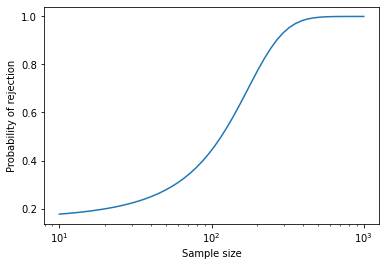

In [15]:
from scipy.special import expit

b, a = results.params
ns = np.logspace(1, 3)
ps = expit(a * ns + b)

plt.plot(ns, ps)
plt.xlabel('Sample size')
plt.ylabel('Probability of rejection')
plt.xscale('log')
plt.savefig("anderson2.png", dpi=300);

When the sample size is more than 200, the probability of rejection is high.
When the sample size is less than 100, the probability of rejection is low. But notice that it doesn't go all the way to zero, because there is always a 5% chance of a false positive.

We can use the parameters of the logistic model to compute the critical value.

In [16]:
from scipy.special import logit

b, a = results.params
n = (logit(0.5) - b) / a - b
n

117.39253624525765

At this sample size, the probability of rejecting the null is close to 50%.

In [17]:
outcomes = [sample_and_test(dist, int(n)) for i in range(1000)]
np.mean(outcomes)

0.483

So, again, the result just depends on the sample size. If you have enough data, you'll reject the null; otherwise you probably won't. Either way, you learn nothing about the question you really care about, which is whether the Gaussian model is a *good enough* model of the data for your purposes.

That's a modeling decision, and no statistical test can help. In [the original article](https://allendowney.blogspot.com/2013/08/are-my-data-normal.html), I suggested some methods that might.

Copyright 2023 Allen Downey

[Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)